In [1]:
using Turing 
using Distributions
using Random
using Statistics
using StatsFuns

using CSVFiles
using DataFrames

using CairoMakie
using StatsPlots
CairoMakie.activate!()

### section 5-3
#### logistic regression 2

In [2]:
df = DataFrame(load(File(format"CSV", "data-attendance-3.txt")))

# A: アルバイトが好き => 1, 嫌い => 0
# Score: 学問への興味: 0 ~ 200
# Weather: A => 晴れ, B => 曇り, C => 雨
# Y: 出席 => 1, 欠席 => 0

Row,PersonID,A,Score,Weather,Y
,Int64,Int64,Int64,String,Int64
1,1,0,69,B,1
2,1,0,69,A,1
3,1,0,69,C,1
4,1,0,69,A,1
5,1,0,69,B,1
6,1,0,69,B,1
7,1,0,69,C,0
8,1,0,69,B,1
9,1,0,69,A,1


In [3]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,PersonID,24.217,1,23.0,50,0,Int64
2,A,0.464942,0,0.0,1,0,Int64
3,Score,122.856,51,122.0,185,0,Int64
4,Weather,,A,,C,0,String
5,Y,0.718698,0,1.0,1,0,Int64


In [4]:
# 集計
counter(weather, y) = nrow(df[(df.Y .== y) .&& (df.Weather .== weather), :])
weathers = ["A", "B", "C"]

df2 = DataFrame(
    Weather = weathers,
    Y_0 = [counter(weather, 0) for weather in weathers],
    Y_1 = [counter(weather, 1) for weather in weathers]
)


Row,Weather,Y_0,Y_1
,String,Int64,Int64
1,A,306,953
2,B,230,500
3,C,138,269


In [5]:
#= Weather の変換
    A: 晴れ -> 0
    B: 曇り -> 0.2
    C: 雨   -> 1
=#

function _converter(weather)
    if weather == "A"
        return 0.0
    elseif weather == "B"
        return 0.2 
    elseif weather == "C" 
        return 1.0
    else
        return NaN64
    end
end

_df = DataFrame(Weather_float = _converter.(df.Weather))
df3 = hcat(df, _df)

Row,PersonID,A,Score,Weather,Y,Weather_float
,Int64,Int64,Int64,String,Int64,Float64
1,1,0,69,B,1,0.2
2,1,0,69,A,1,0.0
3,1,0,69,C,1,1.0
4,1,0,69,A,1,0.0
5,1,0,69,B,1,0.2
6,1,0,69,B,1,0.2
7,1,0,69,C,0,1.0
8,1,0,69,B,1,0.2
9,1,0,69,A,1,0.0


In [6]:
# 出席率をパラメータとする Bernoulli 分布によって Y が予想できる
# Bernoulli 分布: 確率 p で 1, 確率 1-p で 0

@model function bernoulli(A, Score, Weather_float, Y)
    # prior distribution
    b_0 ~ Normal(0, 100)
    b_A ~ Normal(0, 100)
    b_score ~ Normal(0, 100)
    b_weather ~ Normal(0, 100)

    # scaling 
    score_scale = 200

    # model
    for i = 1 : length(A)
        Y[i] ~ BernoulliLogit(b_0 + b_A * A[i] + (b_score / score_scale) * Score[i] + b_weather * Weather_float[i])
    end
end

bernoulli (generic function with 2 methods)

In [7]:
A = df3[!, :A]
Score = df3[!, :Score]
Y = df3[!, :Y]
Weather_float = df3[!, :Weather_float]
chain = sample(bernoulli(A, Score, Weather_float, Y), NUTS(), 1000)

┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (1000×18×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 14.99 seconds
Compute duration  = 14.99 seconds
parameters        = b_0, b_A, b_score, b_weather
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

         b_0    0.1821    0.2262    0.0140   258.8335   253.8863    1.0062     ⋯
         b_A   -0.6192    0.0915    0.0034   709.7036   676.4312    0.9991     ⋯
     b_score    1.9350    0.3602    0.0211   292.0546   369.6237    1.0039     ⋯
   b_weather   -0.4535    0.1244    0.0048   690.5377   590.4709    1.0031     ⋯
                   

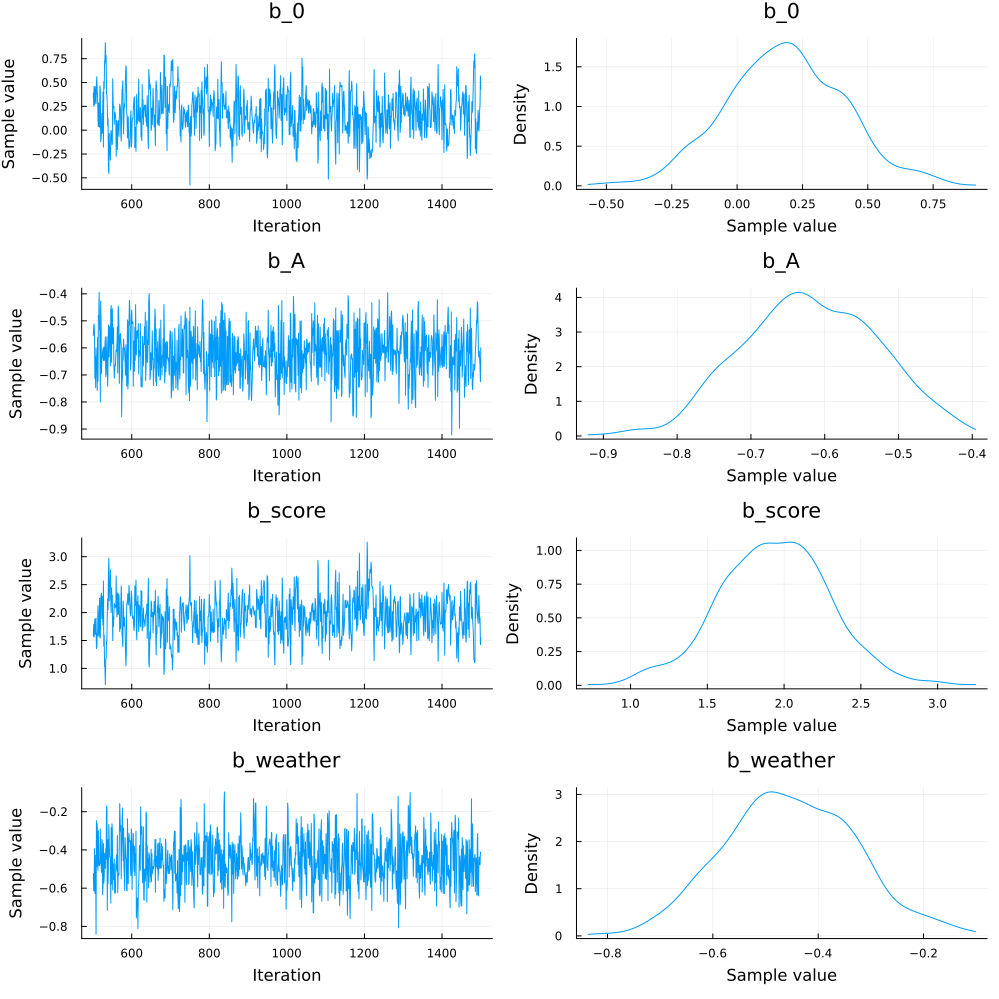

In [8]:
StatsPlots.plot(chain)

In [9]:
score_pred = collect(1 : 200)

# A = 0, Weather: 晴れ
p = StatsFuns.logistic.(chain[:b_0] .+ chain[:b_A] .* 0 .+ (chain[:b_score] * score_pred' ./ 200) .+ chain[:b_weather] .* 0)
mean_p = vec(mean(p, dims=1)')
N = length(df3[(df3.A .== 0) .&& (df3.Weather .== "A"), :Y])

# 80% 信頼区間
lower_conf = [quantile(p[:, i], 0.10) for i = 1 : 200]
upper_conf = [quantile(p[:, i], 0.90) for i = 1 : 200]

200-element Vector{Float64}:
 0.6150942103181682
 0.6169357207125821
 0.6187738809998654
 0.6205868476582634
 0.6223730003071353
 0.6241558365114015
 0.6259353142392201
 0.6278115907150147
 0.6296874970247583
 0.6313576649413399
 0.6333231311582799
 0.6351447566904637
 0.6368682256361948
 ⋮
 0.8999963596199475
 0.9010103772393858
 0.9020227116293354
 0.9029947553588206
 0.9039651270372128
 0.9049688297837917
 0.9059258544513701
 0.9069216429357534
 0.9079393134273288
 0.9089464528259747
 0.9099031537541238
 0.9108777134063859

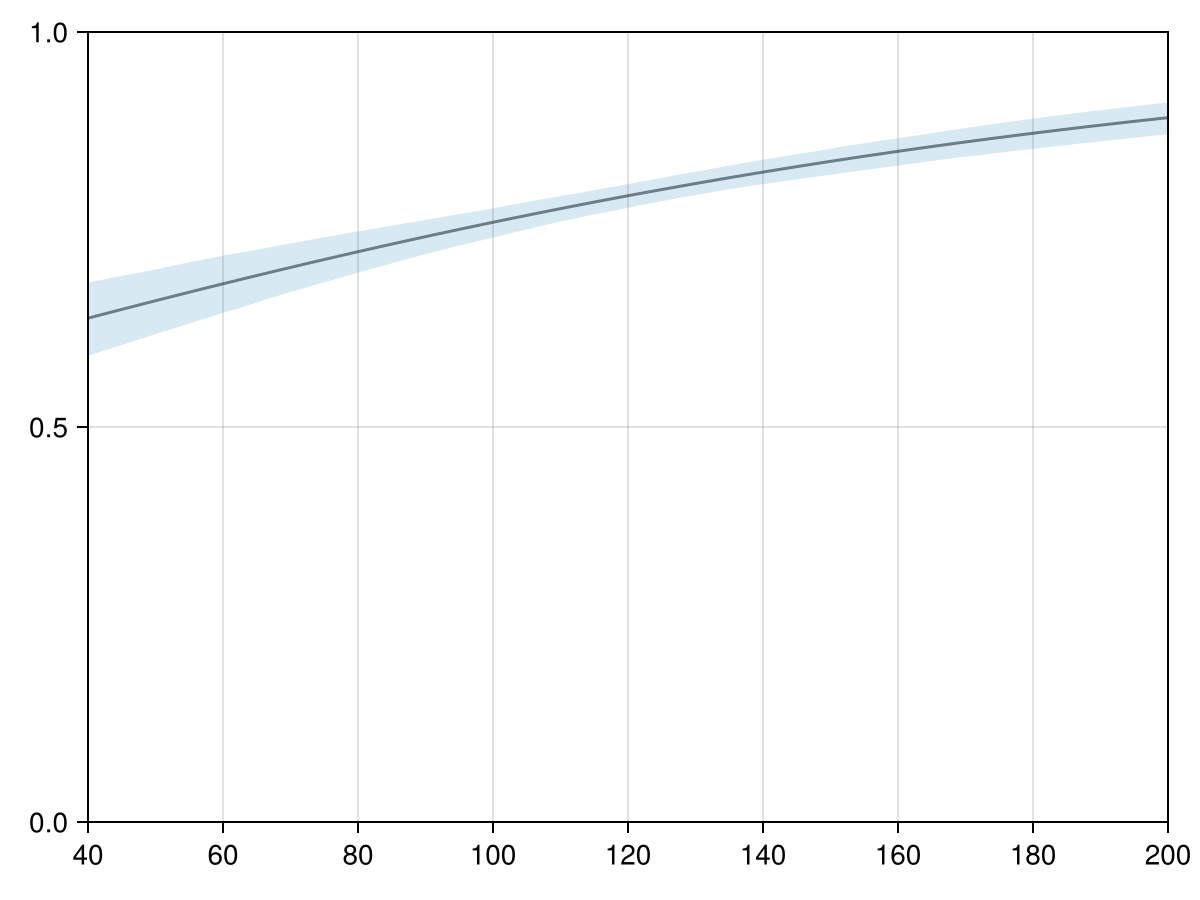

CairoMakie.Screen{IMAGE}


In [10]:
# 80% prediction interval
fig = Figure()
ax = Axis(fig[1, 1], limits = ((40, 200), (0.0, 1.0)))

Makie.lines!(ax, 40:200, mean_p[40:200], color = (:black, 0.5))
Makie.band!(ax, 40:200, lower_conf[40:200], upper_conf[40:200], alpha=0.2)

display(fig)

In [33]:
# ROC 曲線
function roc_plot(true_probs, false_probs)
    x, y = _roc(true_probs, false_probs)      # plots
    auc = _area_under_the_curve(x, y)               
    
    fig = Figure(size=(500, 500))
    ax = Axis(fig[1, 1], limits = ((0.0, 1.0), (0.0, 1.0)), title = "Receiver Operating Characteristic curve")

    Makie.lines!(ax, y, x, color = :blue)
    Makie.lines!(ax, 0:0.1:1, x -> x, color = (:black, 0.5))
    Makie.text!(ax, 0.65, 0.2, text = "AUC = $(round(auc, digits=2))", align = (:center, :center), fontsize = 50)

    display(fig)
end

function _area_under_the_curve(x, y)
    # trapezoidal integration
    area = 0.0
    for i = 2 : length(x)
        area += 0.5 * (x[i] + x[i-1]) * (y[i] - y[i-1])
    end
    return area
end

function _roc(true_probs, false_probs; N=100)
    ϵ = 1.0 / N
    
    prob_criterion = 0.0
    x = [0.0]
    y = [0.0]
    for i = 1 : N 
        prob_criterion += ϵ
        true_positive = _roc_sample_prob(vec(true_probs), prob_criterion)
        false_positive = _roc_sample_prob(vec(false_probs), prob_criterion)
        
        push!(x, false_positive)
        push!(y, true_positive)
    end

    return x, y
end

function _roc_sample_prob(probs, criterion)
    N = length(probs)
    counter = 0
    for i = 1 : N
        if probs[i] < criterion
            counter += 1
        end
    end

    return counter / N
end

_roc_sample_prob (generic function with 1 method)

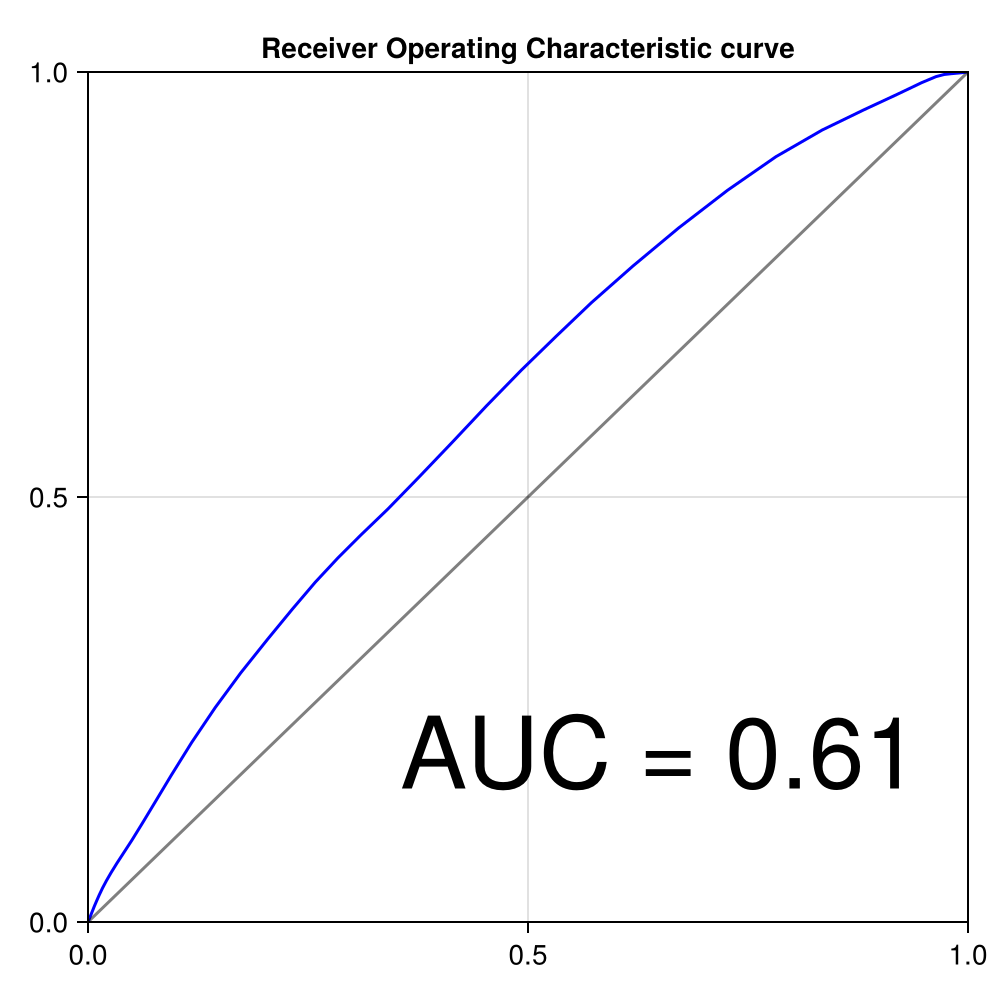

CairoMakie.Screen{IMAGE}


In [34]:
prob_attended = StatsFuns.logistic.(chain[:b_0] .+ chain[:b_A] * df3[df3.Y .== 1, :A]' .+ (chain[:b_score] * df3[df3.Y .== 1, :Score]' ./ 200) .+ chain[:b_weather] * df3[df3.Y .== 1, :Weather_float]')
prob_not_attended = StatsFuns.logistic.(chain[:b_0] .+ chain[:b_A] * df3[df3.Y .== 0, :A]' .+ (chain[:b_score] * df3[df3.Y .== 0, :Score]' ./ 200) .+ chain[:b_weather] * df3[df3.Y .== 0, :Weather_float]')

roc_plot(prob_attended, prob_not_attended)